In [73]:
import numpy as np
from FormFactor import FormFactor
import matplotlib.pyplot as plt

def WL(BeamEnergy): # electron wavelength in Angstroms
    return 0.02426*((BeamEnergy/510.9989)**2+(2*BeamEnergy/510.9989))**(-.5) 

def make_diffraction(coord_dict,beam_energy,output_pixels,q_max,axis_0=0,axis_1=2):
    '''
    calculates diffraction pattern for atoms and coordinates supplied in coord_dict.
    beam_energy in keV, q_max in angstrom-1.
    '''
    
    #create arrays for output. These can be uncommented to provide the real and imaginary parts 
    #as well as the phase in addition to the diffracted intensities.
    
    #patt_re=np.zeros([output_pixels,output_pixels],dtype="float64")
    #patt_im=np.zeros([output_pixels,output_pixels],dtype="float64")
    #patt_arg=np.zeros([output_pixels,output_pixels],dtype="float64")
    patt_int=np.zeros([output_pixels,output_pixels],dtype="float64")
    
    lam=WL(beam_energy)
    scale = (2*q_max)/(output_pixels)
    
    for x in range(0,output_pixels):
        for z in range(0,output_pixels):
            #convert coordinates to those native to problem
            argx=x*scale-q_max
            argz=z*scale-q_max
            argnorm=np.sqrt(argx**2+argz**2)
            #calculate scattering amplitudes
            amp1=[FormFactor(argnorm,kk)*np.exp(2*np.pi*1j*argx*coord_dict[kk][:,axis_0])*np.exp(2*np.pi*1j*argz*coord_dict[kk][:,axis_1]) for kk in coord_dict.keys()]
            amp2=[aa.sum() for aa in amp1]
            amp3=sum(amp2)
            
            #generate outputs. uncomment and change return to produce additional outputs
            
            #patt_re[z,x] = amp3.real
            #patt_im[z,x] = amp3.imag
            #patt_arg[z,x] = np.angle(amp3)
            patt_int[z,x]=abs(amp3)**2
    
    #normalize
    patt_int = patt_int/patt_int.ravel().max()
    return patt_int

## Example: Single-wall carbon nanotube

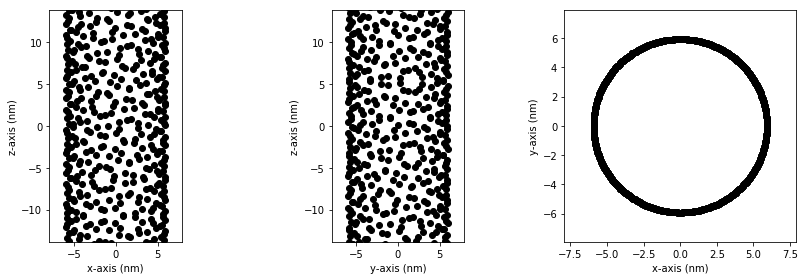

In [62]:
#sknano generates atom positions for nano materials
from sknano.generators import SWNTGenerator 
from sknano.generators import GrapheneGenerator
from sknano.generators import MWNTGenerator

SWTube1 = SWNTGenerator(5,12,Lz=10) #generates a 5,12 single-wall carbon nanotube with 10 unit cells
#SWTube1 = MWNTGenerator(Nwalls=2,min_wall_diameter=11,Lz=10) #generates a double wall tube
#SWTube1 = GrapheneGenerator(armchair_edge_length=4,zigzag_edge_length=4,nlayers=1) #generates graphene

coor=SWTube1.atoms.get_coords()

coor = coor - coor.mean(0)
fig =plt.figure(figsize=(12,4))

#plots of different projections to make sure atoms are correct
xy = coor[:,0]
zy = coor[:,2]
ax1 = fig.add_subplot(1,3,1,adjustable='box',aspect=1)
ax1.set_xlabel('x-axis (nm)')
ax1.set_ylabel('z-axis (nm)')
ax1.set_xlim(xy.min()-2,xy.max()+2)
ax1.set_ylim(2*xy.min()-2,2*xy.max()+2)

ax1.plot(xy,zy,'ko')

yx = coor[:,1]
zx = coor[:,2]
ax2 = fig.add_subplot(1,3,2,adjustable='box',aspect=1)
ax2.set_xlabel('y-axis (nm)')
ax2.set_ylabel('z-axis (nm)')
ax2.plot(yx,zx,'ko')
ax2.set_xlim(yx.min()-2,yx.max()+2)
ax2.set_ylim(2*yx.min()-2,2*yx.max()+2)

xz = coor[:,0]
yz = coor[:,1]
ax3 = fig.add_subplot(1,3,3,adjustable='box',aspect=1)
ax3.set_xlabel('x-axis (nm)')
ax3.set_ylabel('y-axis (nm)')
ax3.plot(xz,yz,'ko')
ax3.set_xlim(xz.min()-2,yz.max()+2)
ax3.set_ylim(xz.min()-2,yz.max()+2)

plt.tight_layout()

plt.show()

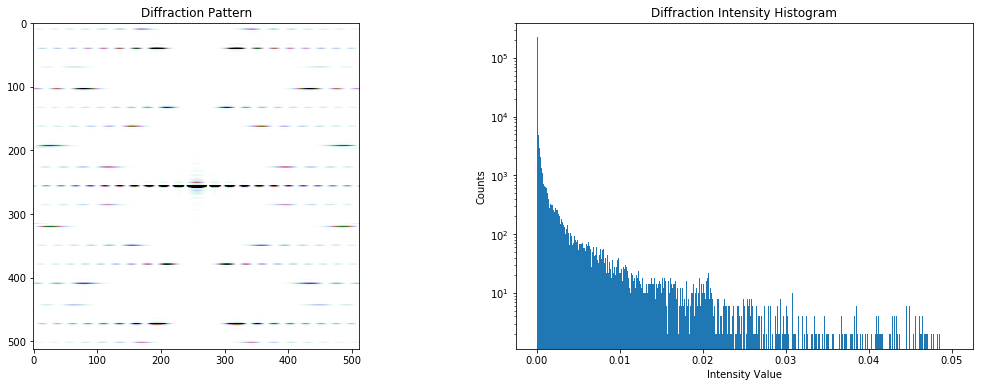

In [30]:
#calcuate diffraction from a nanotube, output pattern and histogram for contrast limit settings

qmax = (2/(3*SWTube1.bond))*2
ImagePixels = 512
energy = 200
lam = WL(energy)

a = make_diffraction({'C':coor},energy,ImagePixels,qmax)

fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].imshow(a,cmap='cubehelix_r',vmin=0,vmax=0.03)
ax[0].set_title('Diffraction Pattern')
ax[1].hist(a.ravel(),bins=np.linspace(0,0.05,500))
ax[1].set_yscale('log')
ax[1].set_title('Diffraction Intensity Histogram')
ax[1].set_xlabel('Intensity Value')
ax[1].set_ylabel('Counts')

plt.show()

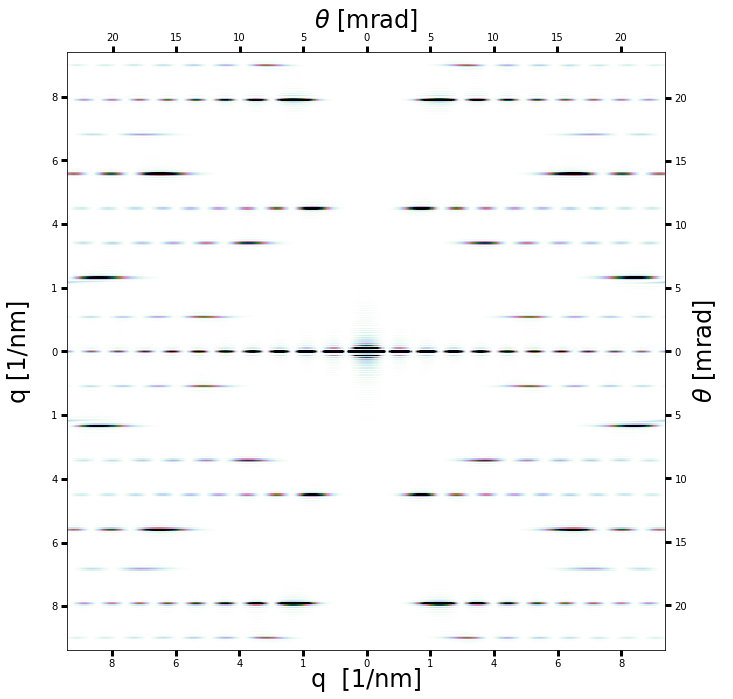

In [57]:
#fancy plotting example
from mpl_toolkits.axes_grid1.parasite_axes import SubplotHost

qdiv=0.2
qdivmax=0.8
scale = (2*qmax)/(ImagePixels)
MaxAngle = 20 # in mrads

qticks=abs((ImagePixels/2)+np.linspace(-qdivmax,qdivmax,int((2*qdivmax/qdiv)+1))/scale)
qlabels=10*abs(np.linspace(-qdivmax,qdivmax,int((2*qdivmax/qdiv)+1)))
qlabels = qlabels.astype(int)

AngDiv=5
thetaticks=abs((ImagePixels/2)+np.linspace(-MaxAngle,MaxAngle,int((2*MaxAngle/AngDiv)+1))/(scale*lam*1000))
thetalabels=abs(np.linspace(-MaxAngle,MaxAngle,int(2*MaxAngle/AngDiv)+1))
thetalabels=thetalabels.astype(int)

fig = plt.figure(figsize=(11,11))
ax_q=SubplotHost(fig,1,1,1,aspect=1)
ax_theta=ax_q.twin()
fig.add_subplot(ax_q)

imgplt=plt.imshow(a,interpolation="none",cmap='cubehelix_r',vmin=0,vmax=0.02)


ax_q.axis["bottom"].set_label('q  [1/nm]')
ax_q.xaxis.set_ticks(qticks)
ax_q.xaxis.set_ticklabels(qlabels)
ax_q.xaxis.set_tick_params(width=3,color="k",length=6)
ax_q.xaxis.get_label().set_fontsize(24)
ax_q.xaxis.set_label_coords(.5,-.03)

ax_q.axis["left"].set_label('q [1/nm]')
ax_q.yaxis.set_ticks(qticks)
ax_q.yaxis.set_ticklabels(qlabels)
ax_q.yaxis.set_tick_params(width=3,color="k",length=6)
ax_q.yaxis.get_label().set_fontsize(24)
ax_q.yaxis.set_label_coords(-.06,.5)

ax_theta.axis["top"].set_label(r'$\theta$' +' [mrad]')
ax_theta.xaxis.set_ticks(thetaticks)
ax_theta.xaxis.set_ticklabels(thetalabels)
ax_theta.xaxis.set_tick_params(width=3,color="k",length=6)
ax_theta.xaxis.get_label().set_fontsize(24)
ax_theta.xaxis.set_label_coords(.5,1.04)

ax_theta.axis["right"].set_label(r'$\theta$' +' [mrad]')
ax_theta.yaxis.set_ticks(thetaticks)
ax_theta.yaxis.set_ticklabels(thetalabels)
ax_theta.yaxis.set_tick_params(width=3,color="k",length=6)
ax_theta.yaxis.get_label().set_fontsize(24)

plt.show()
#plt.savefig("name.png", bbox_inches='tight',dpi=300)

## Example: Single-wall boron nitride nanotube

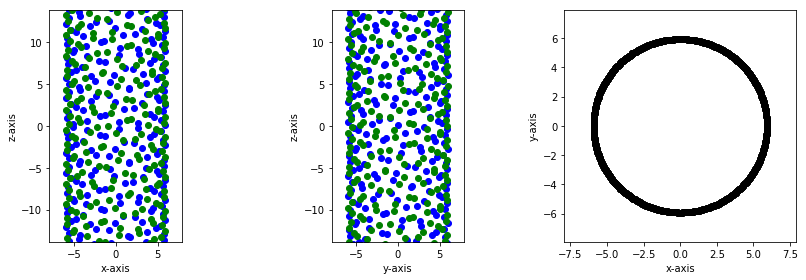

In [63]:
#Boron nitride nanotube example

SWTube1 = SWNTGenerator(5,12,Lz=10,basis=['B','N'])

elems = np.array([mm.element for mm in SWTube1.atoms])
coor = np.array([[mm.x,mm.y,mm.z] for mm in SWTube1.atoms])

coorB = np.array([[mm.x,mm.y,mm.z] for mm in SWTube1.atoms if mm.element == 'B'])
coorB = coorB - coor.mean(0)
coorN = np.array([[mm.x,mm.y,mm.z] for mm in SWTube1.atoms if mm.element == 'N'])
coorN = coorN - coor.mean(0)

coor = coor - coor.mean(0)

fig =plt.figure(figsize=(12,4))

xy = coor[:,0]
zy = coor[:,2]

xyB = coorB[:,0]
zyB = coorB[:,2]

xyN = coorN[:,0]
zyN = coorN[:,2]

ax1 = fig.add_subplot(1,3,1,adjustable='box',aspect=1)
ax1.set_xlabel('x-axis')
ax1.set_ylabel('z-axis')
ax1.set_xlim(xy.min()-2,xy.max()+2)
ax1.set_ylim(2*xy.min()-2,2*xy.max()+2)

ax1.plot(xyB,zyB,'bo')
ax1.plot(xyN,zyN,'go')

yx = coor[:,1]
zx = coor[:,2]

yxB = coorB[:,1]
zxB = coorB[:,2]

yxN = coorN[:,1]
zxN = coorN[:,2]

ax2 = fig.add_subplot(1,3,2,adjustable='box',aspect=1)
ax2.set_xlabel('y-axis')
ax2.set_ylabel('z-axis')

ax2.plot(yxB,zxB,'bo')
ax2.plot(yxN,zxN,'go')

ax2.set_xlim(yx.min()-2,yx.max()+2)
ax2.set_ylim(2*yx.min()-2,2*yx.max()+2)

xz = coor[:,0]
yz = coor[:,1]

xzB = coorB[:,0]
yzB = coorB[:,1]

xzN = coorN[:,0]
yzN = coorN[:,1]

ax3 = fig.add_subplot(1,3,3,adjustable='box',aspect=1)
ax3.set_xlabel('x-axis')
ax3.set_ylabel('y-axis')

ax3.plot(xz,yz,'ko')

ax3.set_xlim(xz.min()-2,yz.max()+2)
ax3.set_ylim(xz.min()-2,yz.max()+2)

plt.tight_layout()

plt.show()

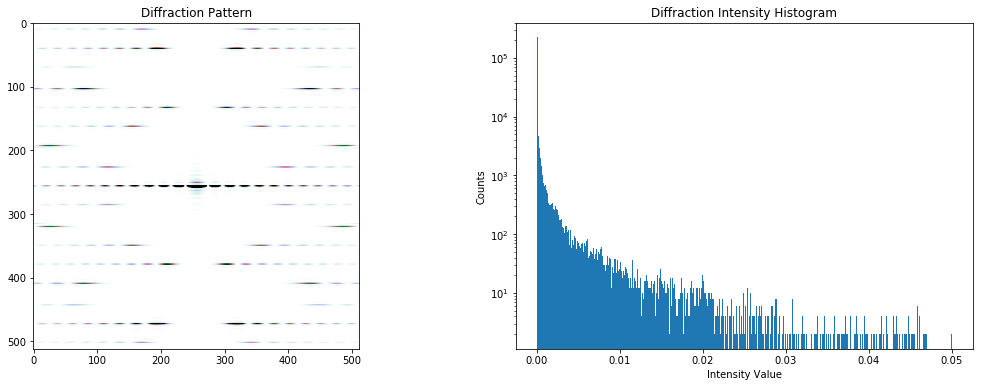

In [64]:
qmax = (2/(3*SWTube1.bond))*2
ImagePixels = 512
energy = 200
lam = WL(energy)

coord_dict = {'B':coorB,'N':coorN}

a = make_diffraction(coord_dict,energy,ImagePixels,qmax)

fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].imshow(a,cmap='cubehelix_r',vmin=0,vmax=0.03)
ax[0].set_title('Diffraction Pattern')
ax[1].hist(a.ravel(),bins=np.linspace(0,0.05,500))
ax[1].set_yscale('log')
ax[1].set_title('Diffraction Intensity Histogram')
ax[1].set_xlabel('Intensity Value')
ax[1].set_ylabel('Counts')

plt.show()

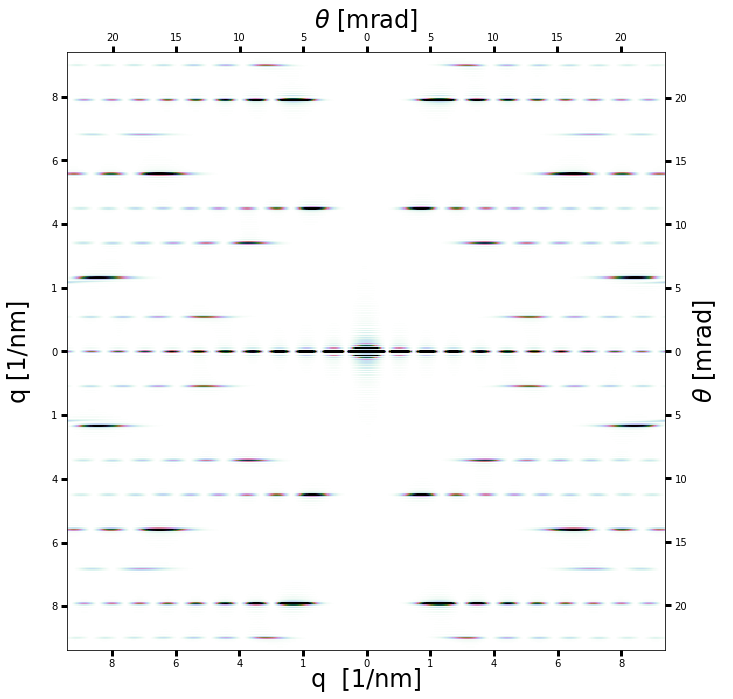

In [65]:
#fancy plotting example
from mpl_toolkits.axes_grid1.parasite_axes import SubplotHost

qdiv=0.2
qdivmax=0.8
scale = (2*qmax)/(ImagePixels)
MaxAngle = 20 # in mrads

qticks=abs((ImagePixels/2)+np.linspace(-qdivmax,qdivmax,int((2*qdivmax/qdiv)+1))/scale)
qlabels=10*abs(np.linspace(-qdivmax,qdivmax,int((2*qdivmax/qdiv)+1)))
qlabels = qlabels.astype(int)

AngDiv=5
thetaticks=abs((ImagePixels/2)+np.linspace(-MaxAngle,MaxAngle,int((2*MaxAngle/AngDiv)+1))/(scale*lam*1000))
thetalabels=abs(np.linspace(-MaxAngle,MaxAngle,int(2*MaxAngle/AngDiv)+1))
thetalabels=thetalabels.astype(int)

fig = plt.figure(figsize=(11,11))
ax_q=SubplotHost(fig,1,1,1,aspect=1)
ax_theta=ax_q.twin()
fig.add_subplot(ax_q)

imgplt=plt.imshow(a,interpolation="none",cmap='cubehelix_r',vmin=0,vmax=0.02)


ax_q.axis["bottom"].set_label('q  [1/nm]')
ax_q.xaxis.set_ticks(qticks)
ax_q.xaxis.set_ticklabels(qlabels)
ax_q.xaxis.set_tick_params(width=3,color="k",length=6)
ax_q.xaxis.get_label().set_fontsize(24)
ax_q.xaxis.set_label_coords(.5,-.03)

ax_q.axis["left"].set_label('q [1/nm]')
ax_q.yaxis.set_ticks(qticks)
ax_q.yaxis.set_ticklabels(qlabels)
ax_q.yaxis.set_tick_params(width=3,color="k",length=6)
ax_q.yaxis.get_label().set_fontsize(24)
ax_q.yaxis.set_label_coords(-.06,.5)

ax_theta.axis["top"].set_label(r'$\theta$' +' [mrad]')
ax_theta.xaxis.set_ticks(thetaticks)
ax_theta.xaxis.set_ticklabels(thetalabels)
ax_theta.xaxis.set_tick_params(width=3,color="k",length=6)
ax_theta.xaxis.get_label().set_fontsize(24)
ax_theta.xaxis.set_label_coords(.5,1.04)

ax_theta.axis["right"].set_label(r'$\theta$' +' [mrad]')
ax_theta.yaxis.set_ticks(thetaticks)
ax_theta.yaxis.set_ticklabels(thetalabels)
ax_theta.yaxis.set_tick_params(width=3,color="k",length=6)
ax_theta.yaxis.get_label().set_fontsize(24)

plt.show()
#plt.savefig("name.png", bbox_inches='tight',dpi=300)

## Example: Monolayer WS2 with a 5 nm probe

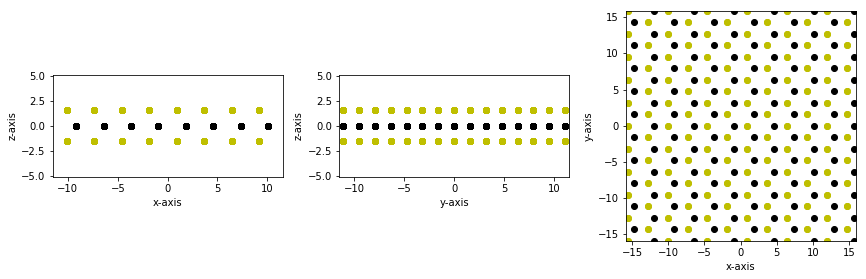

In [85]:
#WS2 lattice parameters
LatticeA = 3.18 #angstroms 
LatticeC = 12.5/2 #angstroms
BasisZ = 0.25*LatticeC #angstroms
a1 = LatticeA*np.array([np.sqrt(3)/2.0,0.5,0])
a2 = LatticeA*np.array([np.sqrt(3)/2.0,-0.5,0])
a3 = LatticeC*np.array([0,0,1])
Basis1 = -(a1+a2)/6
Basis2 = (a1+a2)/6 + BasisZ*np.array([0,0,1])
Basis3 = (a1+a2)/6 - BasisZ*np.array([0,0,1])

#Atom position generation
inplane_num = 100
coor = np.array([i*a1+j*a2+k for i in range(-inplane_num,inplane_num) for j in range(-inplane_num,inplane_num) for k in np.array([Basis1,Basis2,Basis3])])
coorW = np.array([i*a1+j*a2+k for i in range(-inplane_num,inplane_num) for j in range(-inplane_num,inplane_num) for k in np.array([Basis1])])
coorS = np.array([i*a1+j*a2+k for i in range(-inplane_num,inplane_num) for j in range(-inplane_num,inplane_num) for k in np.array([Basis2,Basis3])])

fig,ax =plt.subplots(1,3,figsize=(12,4))
for a in ax:
    a.set_aspect(1)

xy = coor[:,0]
zy = coor[:,2]
xyW = coorW[:,0]
zyW = coorW[:,2]
xyS = coorS[:,0]
zyS = coorS[:,2]

ax[0].set_xlabel('x-axis')
ax[0].set_ylabel('z-axis')
ax[0].set_xlim(-3*LatticeA-2,3*LatticeA+2)
ax[0].set_ylim(-0.5*LatticeC-2,0.5*LatticeC+2)
ax[0].plot(xyW,zyW,'ko')
ax[0].plot(xyS,zyS,'yo')

yx = coor[:,1]
zx = coor[:,2]
yxW = coorW[:,1]
zxW = coorW[:,2]
yxS = coorS[:,1]
zxS = coorS[:,2]

ax[1].set_xlabel('y-axis')
ax[1].set_ylabel('z-axis')
ax[1].set_xlim(-3*LatticeA-2,3*LatticeA+2)
ax[1].set_ylim(-0.5*LatticeC-2,0.5*LatticeC+2)
ax[1].plot(yxW,zxW,'ko')
ax[1].plot(yxS,zxS,'yo')

xz = coor[:,0]
yz = coor[:,1]
xzW = coorW[:,0]
yzW = coorW[:,1]
xzS = coorS[:,0]
yzS = coorS[:,1]

ax[2].set_xlabel('x-axis')
ax[2].set_ylabel('y-axis')
ax[2].set_xlim(-5*LatticeA,5*LatticeA)
ax[2].set_ylim(-5*LatticeA,5*LatticeA)
ax[2].plot(xzW,yzW,'ko')
ax[2].plot(xzS,yzS,'yo')

plt.tight_layout()
plt.show()

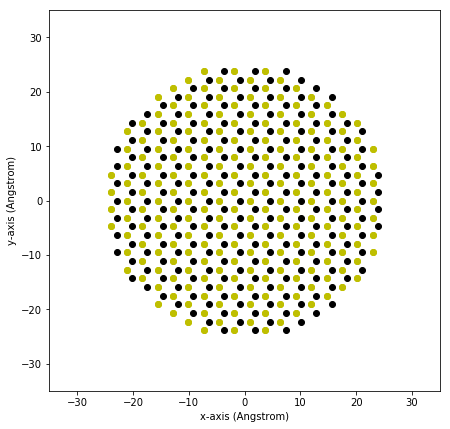

In [86]:
ProbeDiameter = 50# in Angstrom

coorW_crop = np.array([atomW for atomW in coorW if np.linalg.norm(atomW[0:2]) <= ProbeDiameter/2 ])
coorS_crop = np.array([atomS for atomS in coorS if np.linalg.norm(atomS[0:2]) <= ProbeDiameter/2 ])

fig =plt.figure(figsize=(7,7))

plt.plot(coorW_crop[:,0],coorW_crop[:,1],'ko')
plt.plot(coorS_crop[:,0],coorS_crop[:,1],'yo')

plt.xlim(-ProbeDiameter/2-10,ProbeDiameter/2+10)
plt.ylim(-ProbeDiameter/2-10,ProbeDiameter/2+10)

plt.xlabel('x-axis (Angstrom)')
plt.ylabel('y-axis (Angstrom)')

plt.show()

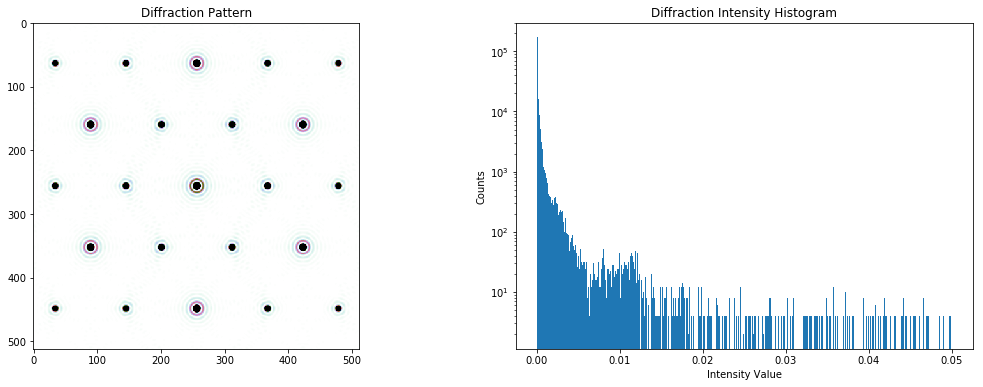

In [87]:
coord_dict = {'W':coorW_crop,'S':coorS_crop}

qmax = (2/(3*LatticeA))*4
ImagePixels = 512
energy = 200
lam = WL(energy)

a = make_diffraction(coord_dict,energy,ImagePixels,qmax,axis_0=0,axis_1=1)

fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].imshow(a,cmap='cubehelix_r',vmin=0,vmax=0.03)
ax[0].set_title('Diffraction Pattern')
ax[1].hist(a.ravel(),bins=np.linspace(0,0.05,500))
ax[1].set_yscale('log')
ax[1].set_title('Diffraction Intensity Histogram')
ax[1].set_xlabel('Intensity Value')
ax[1].set_ylabel('Counts')

plt.show()

## In this example, diffraction intensities are calculated for the same structure as before, but with small random displacements added to each atomic position (thermal diffuse scattering). Multiple simulations are run, and then averaged.

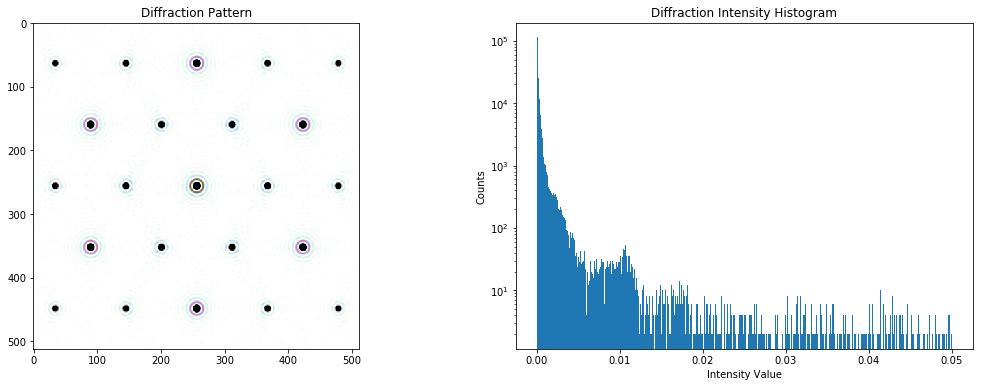

In [88]:
#Takes a while, lower num_simulations to speed up, raise for "better" results

qmax = (2/(3*LatticeA))*4
ImagePixels = 512
energy = 200
lam = WL(energy)

num_simulations = 15
tds_patt = []
for _ in range(0,num_simulations): #Need to look up mean atom displacement numbers from literature
    S_vecs=np.random.normal(0,np.sqrt(0.4965/(8*np.pi**2)),size=(len(coorS_crop),3)) #S
    W_vecs=np.random.normal(0,np.sqrt(0.1634/(8*np.pi**2)),size=(len(coorW_crop),3)) #W
    
    coord_dict = {'W':coorW_crop+W_vecs,'S':coorS_crop+S_vecs}

    a = make_diffraction(coord_dict,energy,ImagePixels,qmax,axis_0=0,axis_1=1)
    tds_patt.append(a)

total=np.array(tds_patt)
b = total.sum(0)/total.sum(0).max()

fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].imshow(b,cmap='cubehelix_r',vmin=0,vmax=0.03)
ax[0].set_title('Diffraction Pattern')
ax[1].hist(b.ravel(),bins=np.linspace(0,0.05,500))
ax[1].set_yscale('log')
ax[1].set_title('Diffraction Intensity Histogram')
ax[1].set_xlabel('Intensity Value')
ax[1].set_ylabel('Counts')

plt.show()

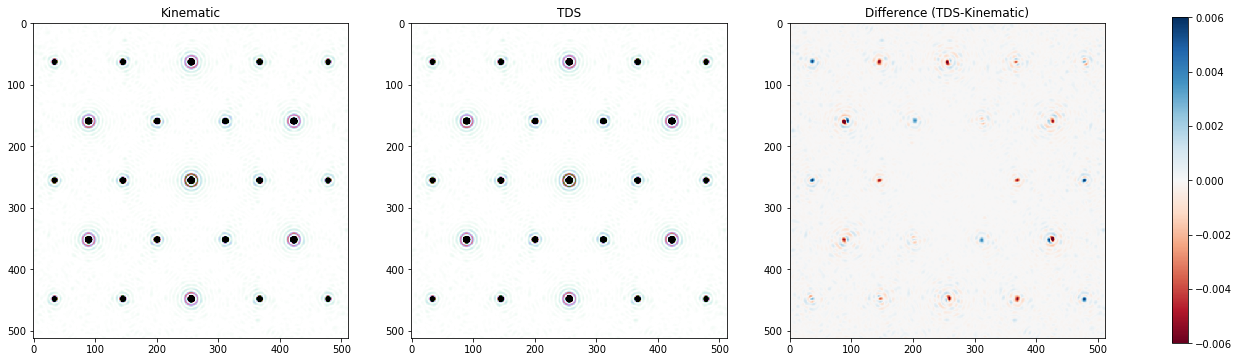

In [93]:
diff = a - b

fig,ax = plt.subplots(1,3,figsize=(24,6))

ax[0].imshow(a,cmap='cubehelix_r',vmin=0,vmax=0.03)
ax[0].set_title('Kinematic')
ax[1].imshow(a,cmap='cubehelix_r',vmin=0,vmax=0.03)
ax[1].set_title('TDS')

im = ax[2].imshow(diff,cmap='RdBu',vmin=-0.006,vmax=0.006)
ax[2].set_title('Difference (TDS-Kinematic)')

plt.colorbar(im,ax=ax)

plt.show()

## Periodic array of 1 nm holes with 2 nm pitch in WS2

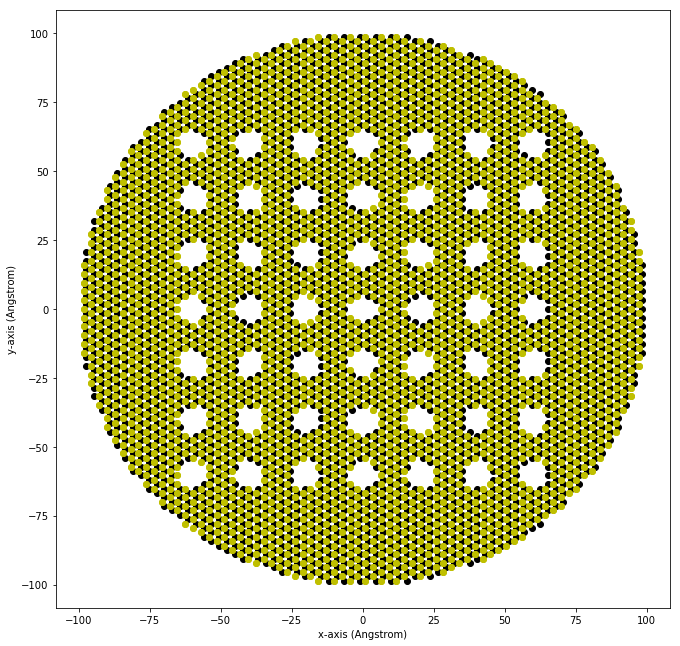

In [81]:
ProbeDiameter = 200# in Angstrom

HoleDiameter = 10 #in Ang
HolePitch = 20 #in Ang
GridSize = 3 # in number of holes

h1 = np.array([HolePitch,0])
h2 = np.array([0,HolePitch])

coorW_holes=np.array([atomW for atomW in coorW if np.linalg.norm(atomW[0:2]) <= ProbeDiameter/2 ])
coorS_holes=np.array([atomS for atomS in coorS if np.linalg.norm(atomS[0:2]) <= ProbeDiameter/2 ])

allholes = np.array([n1*h1+n2*h2 for n1 in range(-GridSize,GridSize+1) for n2 in range(-GridSize,GridSize+1)])

truthw = []
truths = []
for hh in allholes:
    for w in coorW_holes:
        if np.linalg.norm(w[0:2]-hh)<HoleDiameter/2:
            truthw.append(0)
        else:
            truthw.append(1)
    for s in coorS_holes:
        if np.linalg.norm(s[0:2]-hh)<HoleDiameter/2:
            truths.append(0)
        else:
            truths.append(1)

tw = np.array(truthw).reshape((len(allholes),len(coorW_holes)))
tw = np.invert(np.prod(tw,axis=0).astype(bool))
ts = np.array(truths).reshape((len(allholes),len(coorS_holes)))
ts = np.invert(np.prod(ts,axis=0).astype(bool))
coorW_holes = coorW_holes[~tw]
coorS_holes = coorS_holes[~ts]

fig =plt.figure(figsize=(11,11))

plt.plot(coorW_holes[:,0],coorW_holes[:,1],'ko')
plt.plot(coorS_holes[:,0],coorS_holes[:,1],'yo')

#plt.xlim(-ProbeDiameter/2-10,ProbeDiameter/2+10)
#plt.ylim(-ProbeDiameter/2-10,ProbeDiameter/2+10)

plt.xlabel('x-axis (Angstrom)')
plt.ylabel('y-axis (Angstrom)')

plt.show()

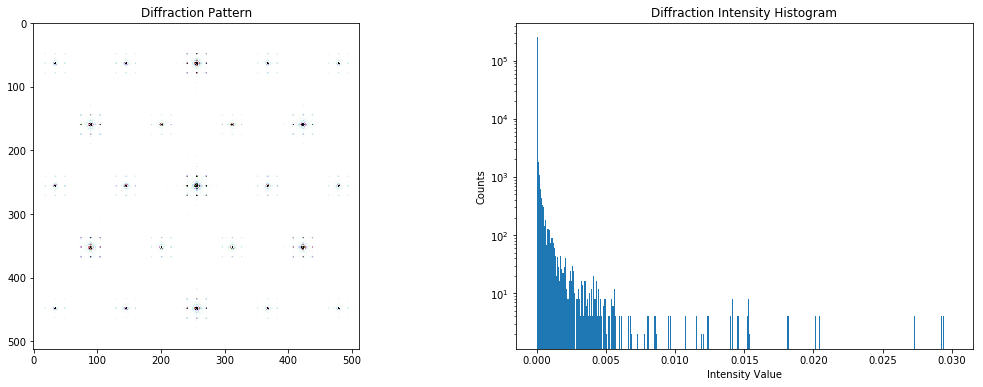

In [83]:
coord_dict = {'W':coorW_holes,'S':coorS_holes}

qmax = (2/(3*LatticeA))*4
ImagePixels = 512
energy = 200
lam = WL(energy)

#a = make_diffraction(coord_dict,energy,ImagePixels,qmax,axis_0=0,axis_1=1)

fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].imshow(a,cmap='cubehelix_r',vmin=0,vmax=0.01)
ax[0].set_title('Diffraction Pattern')
ax[1].hist(a.ravel(),bins=np.linspace(0,0.03,500))
ax[1].set_yscale('log')
ax[1].set_title('Diffraction Intensity Histogram')
ax[1].set_xlabel('Intensity Value')
ax[1].set_ylabel('Counts')

plt.show()

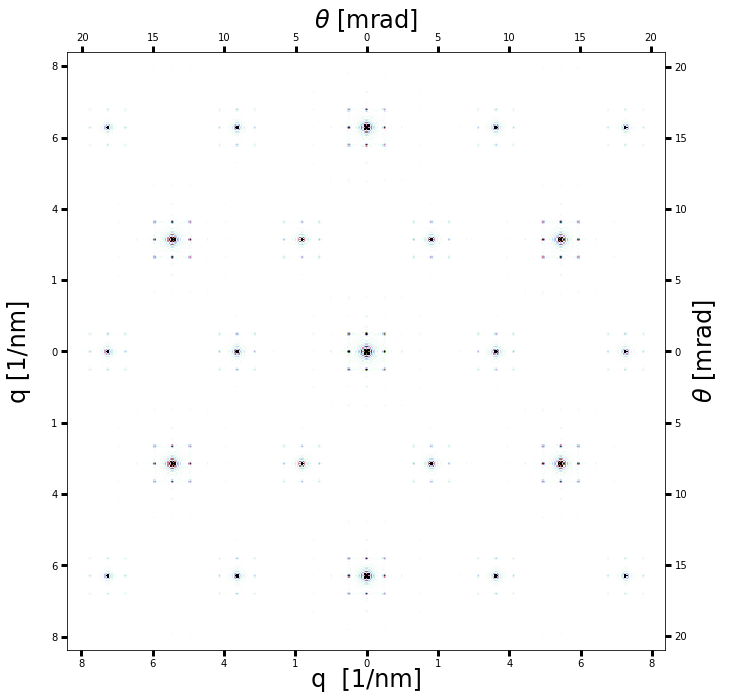

In [84]:
from mpl_toolkits.axes_grid1.parasite_axes import SubplotHost

qdiv=0.2
qdivmax=0.8
scale = (2*qmax)/(ImagePixels)
MaxAngle = 20 # in mrads

qticks=abs((ImagePixels/2)+np.linspace(-qdivmax,qdivmax,int((2*qdivmax/qdiv)+1))/scale)
qlabels=10*abs(np.linspace(-qdivmax,qdivmax,int((2*qdivmax/qdiv)+1)))
qlabels = qlabels.astype(int)

AngDiv=5
thetaticks=abs((ImagePixels/2)+np.linspace(-MaxAngle,MaxAngle,int((2*MaxAngle/AngDiv)+1))/(scale*lam*1000))
thetalabels=abs(np.linspace(-MaxAngle,MaxAngle,int(2*MaxAngle/AngDiv)+1))
thetalabels=thetalabels.astype(int)

fig = plt.figure(figsize=(11,11))
ax_q=SubplotHost(fig,1,1,1,aspect=1)
ax_theta=ax_q.twin()
fig.add_subplot(ax_q)

imgplt=plt.imshow(a,interpolation="none",cmap='cubehelix_r',vmin=0,vmax=0.01)

ax_q.axis["bottom"].set_label('q  [1/nm]')
ax_q.xaxis.set_ticks(qticks)
ax_q.xaxis.set_ticklabels(qlabels)
ax_q.xaxis.set_tick_params(width=3,color="k",length=6)
ax_q.xaxis.get_label().set_fontsize(24)
ax_q.xaxis.set_label_coords(.5,-.03)

ax_q.axis["left"].set_label('q [1/nm]')
ax_q.yaxis.set_ticks(qticks)
ax_q.yaxis.set_ticklabels(qlabels)
ax_q.yaxis.set_tick_params(width=3,color="k",length=6)
ax_q.yaxis.get_label().set_fontsize(24)
ax_q.yaxis.set_label_coords(-.06,.5)

ax_theta.axis["top"].set_label(r'$\theta$' +' [mrad]')
ax_theta.xaxis.set_ticks(thetaticks)
ax_theta.xaxis.set_ticklabels(thetalabels)
ax_theta.xaxis.set_tick_params(width=3,color="k",length=6)
ax_theta.xaxis.get_label().set_fontsize(24)
ax_theta.xaxis.set_label_coords(.5,1.04)

ax_theta.axis["right"].set_label(r'$\theta$' +' [mrad]')
ax_theta.yaxis.set_ticks(thetaticks)
ax_theta.yaxis.set_ticklabels(thetalabels)
ax_theta.yaxis.set_tick_params(width=3,color="k",length=6)
ax_theta.yaxis.get_label().set_fontsize(24)

plt.show()
#plt.savefig("name.png", bbox_inches='tight',dpi=300)